# HoltWinters for Time Series Forecasting

Holt-Winters is a time-series analysis technique, used in both forecasting future entries in a time series as well as in providing exponential smoothing, where weights are assigned against historical data with exponentially decreasing impact. It does this by analyzing three components of the data: level, trend, and seasonality. 

In order to convert your dataset to cudf format please read the cudf documentation on https://rapidsai.github.io/projects/cudf/en/latest/. For additional information on the HoltWinters model please refer to the documentation on https://rapidsai.github.io/projects/cuml/en/latest/index.html

This notebook will demonstrate how to forecast future datapoints using cuML's HoltWinters algorithm by using weather data collected by NOAA at Raleigh-Durham International Airport between 2009 and today. It will predict weather patterns for the next 12 months, including temperature and precipitation. This notebook will also look at the accuracy of a separate prediction on an airpassenger dataset as compared to statsmodels.

In [1]:
#import needed packages

from cuml import HoltWinters
import cudf
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

### Import NOAA RDU Weather Dataset

In [2]:
dl_url = "https://data.townofcary.org/api/v2/catalog/datasets/rdu-weather-history/exports/csv"
data = urllib.request.urlopen(dl_url)
gdf = pd.read_csv(data, sep=';')
gdf.head()

,date,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,...,drizzle,snow,freezingrain,smokehaze,thunder,highwind,hail,blowingsnow,dust,freezingfog
0,2009-10-03,55.0,82.0,0.00,0.0,0.0,2.91,240.0,16.11,230.0,...,No,No,No,No,No,No,No,No,No,No
1,2009-10-10,59.0,79.0,0.02,0.0,0.0,7.83,220.0,17.00,220.0,...,No,No,No,No,No,No,Yes,No,No,No
2,2009-10-14,46.9,61.0,0.14,0.0,0.0,8.72,40.0,14.99,50.0,...,Yes,No,No,No,No,No,Yes,No,No,No
3,2009-10-17,45.0,57.9,0.00,0.0,0.0,6.26,30.0,14.09,40.0,...,No,No,No,No,No,No,No,No,No,No
4,2009-10-29,48.0,68.0,0.00,0.0,0.0,5.82,80.0,14.99,70.0,...,No,No,No,No,No,No,No,No,No,No


### Parse data and groupby month to accumulate average

In [3]:
def date_helper(month):
    if len(str(month)) == 1:
        return '0'+str(month)
    else:
        return str(month)

gdf['date'] = pd.to_datetime(gdf['date']).apply(lambda x : str(x.year) + '-' + date_helper(x.month))

gdf = gdf.groupby('date').mean()
gdf['month'] = gdf.index.map(lambda x : x[-2:])
gdf.tail()

,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,fastest5secwindspeed,month
date,,,,,,,,,,,
2019-03,38.719355,59.680645,0.102258,0.0,0.0,6.522903,192.903226,16.055161,211.290323,22.217742,03
2019-04,51.133333,72.416667,0.212000,0.0,0.0,7.314667,185.333333,18.238000,180.000000,24.546667,04
2019-05,62.680645,84.277419,0.103548,0.0,0.0,6.414839,227.741935,16.870645,194.000000,23.174333,05
2019-06,65.560000,86.333333,0.120000,0.0,0.0,6.443000,172.333333,16.427000,169.333333,22.400333,06
2019-07,71.850000,93.375000,0.211250,0.0,0.0,5.062500,185.000000,16.275000,185.000000,21.278750,07


## Examine Monthly Max/Min Temperature

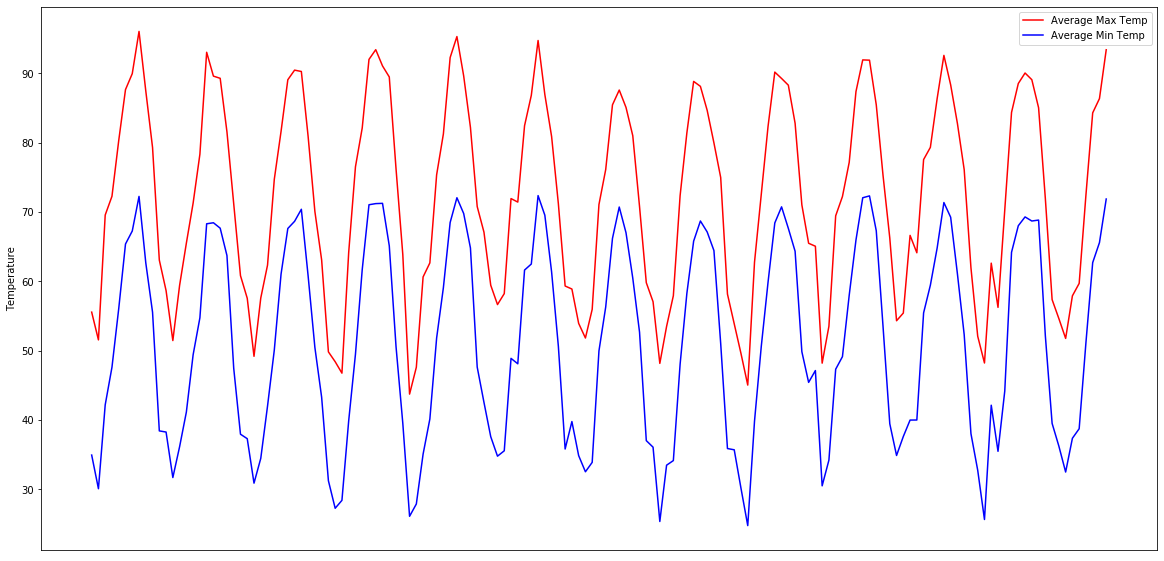

In [4]:
plt.figure(figsize=(20,10))
l1, = plt.plot(gdf['temperaturemax'], color = 'red')
l2, = plt.plot(gdf['temperaturemin'], color = 'blue')
plt.ylabel('Temperature')
plot1 = plt.gca()
plt.legend((l1, l2), ('Average Max Temp', 'Average Min Temp'), loc = 'best')
plot1.axes.get_xaxis().set_ticks([])
plt.show()

## Max/Min Temperature Over Past 2 Years

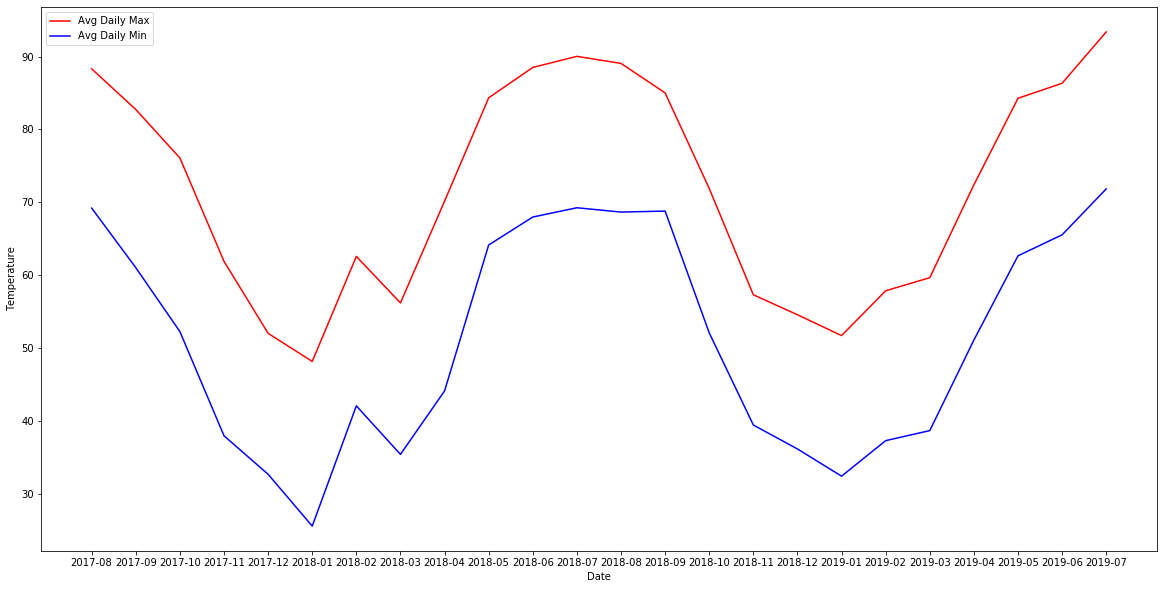

In [5]:
plt.figure(figsize=(20,10))
l1, = plt.plot(gdf.index[-24:], gdf['temperaturemax'].tail(24), color = 'red')
l2, = plt.plot(gdf['temperaturemin'].tail(24), color = 'blue')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.legend((l1, l2), ('Avg Daily Max', 'Avg Daily Min'))
plt.show()

# Forecast Next 12 Months Using HoltWinters

Now we'll use cuML's HoltWinters algorithm to predict the average max/min temperature as well as the precipitation for the next year. Begin by creating a cuDF.Dataframe of the data we want to predict on:

In [6]:
data = cudf.DataFrame.from_pandas(gdf[['temperaturemax','temperaturemin','precipitation']])
data.to_pandas().head()

,temperaturemax,temperaturemin,precipitation
date,,,
2007-01,55.535484,34.922581,0.100645
2007-02,51.532143,30.067857,0.062143
2007-03,69.541935,42.161290,0.113548
2007-04,72.243333,47.593333,0.129333
2007-05,80.287097,56.041935,0.046129


Begin by creating a `HoltWinters` object. Valid parameters include:

- `batch_size` (default=1): number of different time series that will be introduced in `fit()`.
- `freq_season` (default=2): seasonality of the data. As our data is monthly, we set this to 12.
- `season_type` (default='ADDITIVE'): whether the seasonality is "ADDITIVE" or "MULTIPLICATIVE".
- `start_periods` (default=2): number of seasons to be used for seasonal seed values.

Next, fit the object to your data using the `fit()` method. Data can be of type `cudf.dataframe`, `cupy.ndarray`, `numpy.ndarray`, `cuda_array`. Note that `cudf.dataframe` is column major, while the other types are row major. You can also pass the parameter:

- `pointsToForecast` (default=50): number of points you want to forecast.

Finally, use the `predict()` method to return a numpy array of your forecasted points. The first parameter is the index of the time series from data:

- `index` : index of the time series from data from which you want the forecasted points.
- `h` : number of forecasted points to return.

In [7]:
months_to_predict = 12

cu_hw = HoltWinters(batch_size=3, freq_season=12)
cu_hw.fit(data)
tempmax_pred = cu_hw.predict(0, months_to_predict)
tempmin_pred = cu_hw.predict(1, months_to_predict)
precip_pred = cu_hw.predict(2, months_to_predict)

# Compare Forecasted Points With Original Data

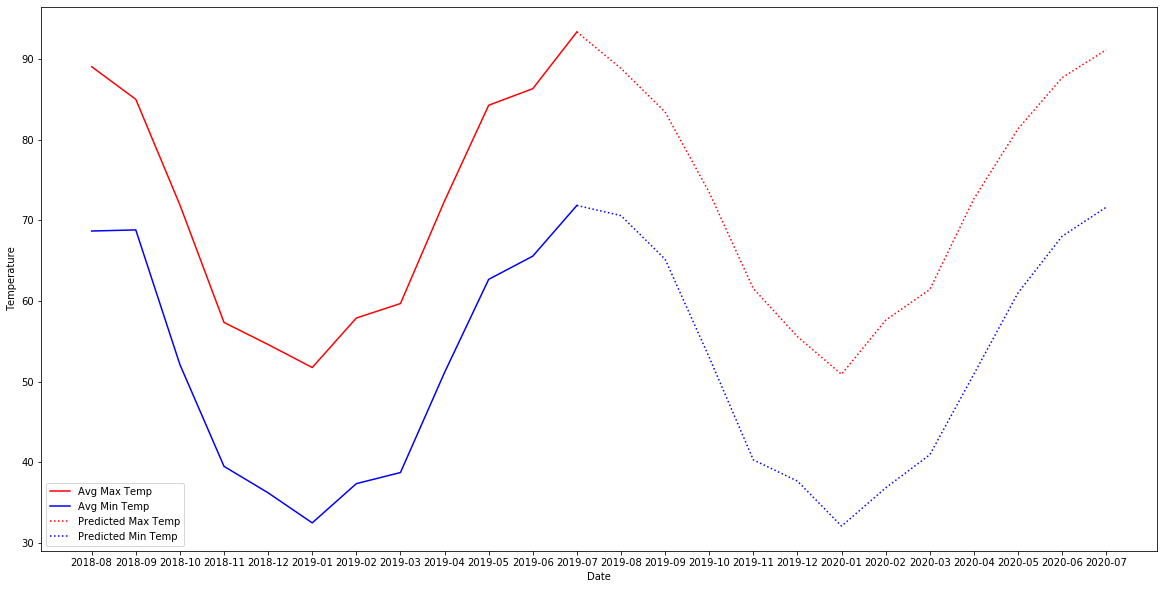

In [8]:
next_six_months = ['2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
                   '2019-12', '2020-01', '2020-02', '2020-03',
                   '2020-04', '2020-05', '2020-06', '2020-07']
tempmax_pred = np.insert(tempmax_pred, 0, gdf['temperaturemax'].iloc[-1])
tempmin_pred = np.insert(tempmin_pred, 0, gdf['temperaturemin'].iloc[-1])
precip_pred = np.insert(precip_pred, 0, gdf['precipitation'].iloc[-1])

plt.figure(figsize=(20,10))
l1, = plt.plot(gdf.index[-12:], gdf['temperaturemax'].tail(12), 'r-')
l2, = plt.plot(gdf.index[-12:], gdf['temperaturemin'].tail(12), 'b-')
p1, = plt.plot(next_six_months, tempmax_pred, 'r:')
p2, = plt.plot(next_six_months, tempmin_pred, 'b:')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.legend((l1, l2, p1, p2), ('Avg Max Temp', 'Avg Min Temp', 'Predicted Max Temp', 'Predicted Min Temp'))
plt.show()

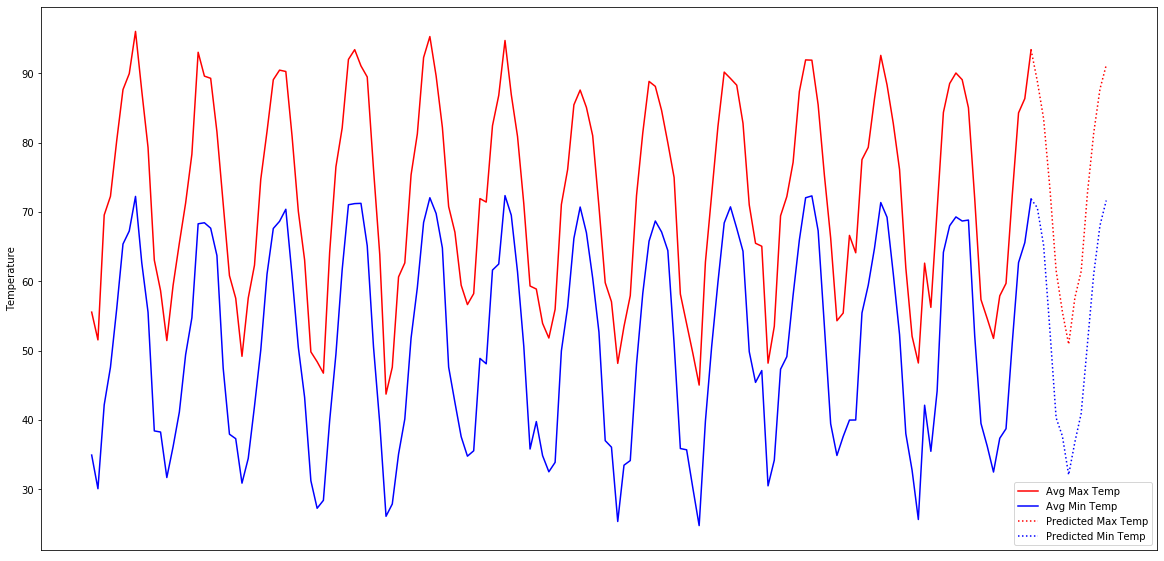

In [9]:
plt.figure(figsize=(20,10))

n = len(gdf.index)

l1, = plt.plot(np.arange(n), gdf['temperaturemax'], 'r-')
l2, = plt.plot(np.arange(n), gdf['temperaturemin'], 'b-')
p1, = plt.plot(np.arange(months_to_predict+1)+n-1, tempmax_pred, 'r:')
p2, = plt.plot(np.arange(months_to_predict+1)+n-1, tempmin_pred, 'b:')
plt.ylabel('Temperature')
plot1 = plt.gca()
plt.legend((l1, l2, p1, p2), ('Avg Max Temp', 'Avg Min Temp', 'Predicted Max Temp', 'Predicted Min Temp'))
plot1.axes.get_xaxis().set_ticks([])
plt.show()

# Examine Precipitation Predictions

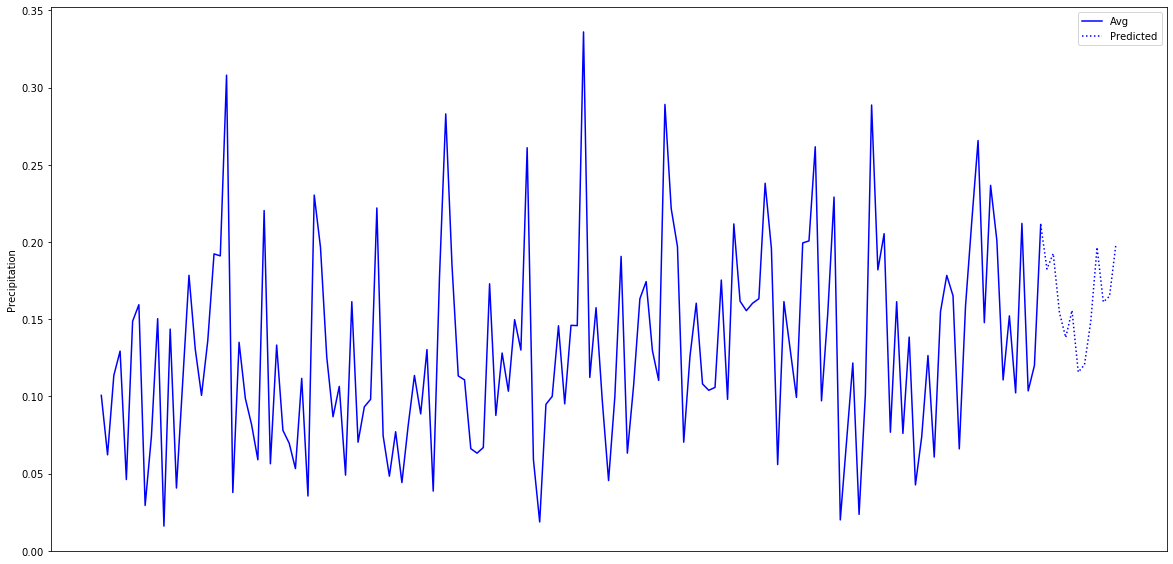

In [10]:
plt.figure(figsize=(20,10))
l1, = plt.plot(np.arange(n), gdf['precipitation'], 'b-')
p1, = plt.plot(np.arange(months_to_predict+1)+n-1, precip_pred, 'b:')
plt.ylabel('Precipitation')
plot1 = plt.gca()
plt.legend((l1, p1), ('Avg', 'Predicted'))
plot1.axes.get_xaxis().set_ticks([])
plt.show()

# Finally, Compare Accuracy to StatsModels

In [11]:
# Airpassengers Dataset
airpassengers = [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
                 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
                 145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
                 171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
                 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
                 204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
                 242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
                 284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
                 315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
                 340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337]

# Test/Train Split
spl = 0.2
airpassengers = np.asarray(airpassengers, dtype=np.float64)
h = int(airpassengers.shape[0]*spl)
train = airpassengers[:-h]
test = airpassengers[-h:]


# cuML HoltWinters
cu_hw = HoltWinters(1, 12)
cu_hw.fit(train)
cu_pred = cu_hw.predict(0, h)

# statsmodels ExponentialSmoothing
sm_hw = ExponentialSmoothing(train, seasonal='additive', seasonal_periods=12)
sm_hw = sm_hw.fit()
sm_pred = sm_hw.forecast(h)

cu_r2 = r2_score(cu_pred, test)
sm_r2 = r2_score(sm_pred, test)

/conda/envs/rapids/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [12]:
print('cuML accuracy score: ' + str(cu_r2))
print('statsmodels accuracy score: ' + str(sm_r2))

cuML accuracy score: 0.7915033949684623
statsmodels accuracy score: 0.06594920441424779
